# 2. Model Construction 

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix)
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("completed_data.csv")

For building the model, it is important to try to minimize the chances of data leaks by separating the variable to be predicted.

In [3]:
# Separate the target variable to avoid data leakage
# Save features (independent variables) in 'X' and target (dependent variable) in 'y'
X = data.drop(columns=['target'])  # All columns except the target
y = data['target']  # Only the target column

# Print a summary to confirm the separation
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)


Features (X) shape: (95919, 40)
Target (y) shape: (95919,)


## 2.1. Data Normalization

The data must be normalized so that some variables do not carry more weight than they should simply because their numerical value is larger. Additionally, normalization helps better meet the assumptions of linear regression.

In [4]:
# List of numeric variables to normalize
numeric_vars = [
    'BureauScoreValue', 'CurrentInterestRate', 'CurrentInterestRateMargin',
    'CurrentValuationAmount', 'CurrentBalance', 'OriginalBalance',
    'LoanAge', 'CLTV', 'TotalIncome', 'MovingAvg3200_PoolCutoff',
    'MovingAvg3200_LoanOrigination', 'MovingAvg3200_LoanMaturity',
    'DurationLoan', 'AgeAtLoanOrigination', 'Missing_AgeAtLoanOrigination'
]


scaler = StandardScaler()
X_normalized = X.copy()
X_normalized[numeric_vars] = scaler.fit_transform(X[numeric_vars])


print(X_normalized[numeric_vars].describe())
print(X_normalized.head())

       BureauScoreValue  CurrentInterestRate  CurrentInterestRateMargin  \
count      9.591900e+04         9.591900e+04               9.591900e+04   
mean       1.896381e-16        -4.124628e-16               9.481903e-18   
std        1.000005e+00         1.000005e+00               1.000005e+00   
min       -3.449494e+00        -2.230912e+00              -1.018624e+00   
25%       -1.036689e+00        -6.192796e-01              -1.018624e+00   
50%        2.259134e-01         1.614669e-01              -3.922203e-01   
75%        6.957976e-01         9.851903e-01               1.134309e+00   
max        2.635338e+00         8.943075e+00               2.666102e+00   

       CurrentValuationAmount  CurrentBalance  OriginalBalance       LoanAge  \
count            9.591900e+04    9.591900e+04     9.591900e+04  9.591900e+04   
mean            -7.348475e-17    8.533713e-17    -7.348475e-17 -1.896381e-17   
std              1.000005e+00    1.000005e+00     1.000005e+00  1.000005e+00   
min 

## 2.2. Correlation

Correlation is an issue for linear regression models, and studying it can provide insight into how the model will perform. Additionally, it allows for identifying relationships that might have gone unnoticed during data processing.

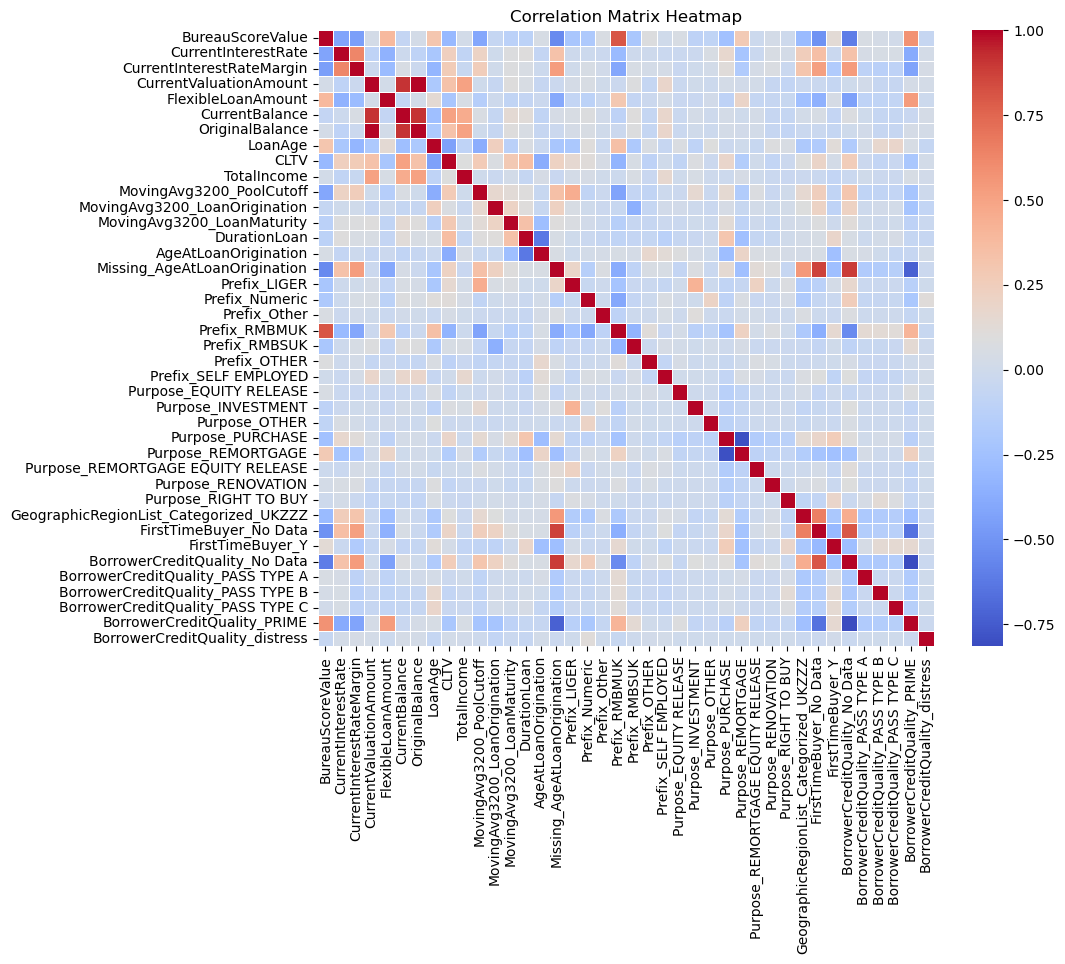

In [5]:
# Compute the correlation matrix
correlation_matrix = X_normalized.corr()

# Display basic statistics about the correlation matrix
max_corr = correlation_matrix.abs().max().max()
min_corr = correlation_matrix.abs().min().min()
mean_corr = correlation_matrix.abs().mean().mean()
summary_stats = pd.DataFrame({
    "Metric": ["Max Correlation", "Min Correlation", "Mean Correlation"],
    "Value": [max_corr, min_corr, mean_corr]
})

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=False, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True, 
    linewidths=0.5
)
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation does not seem excessively strong. In future steps, it would be worthwhile to investigate pairs of variables with strong correlation.

## 2.3. Colineality Study

Linear models are highly sensitive to collinearity. An in-depth analysis of it is necessary to determine whether the model will be significantly affected. With datasets this large, collinearity issues are very common.

There are several ways to calculate collinearity, such as Variance Inflation Factors (VIF) and Condition Indices. Although Condition Indices can provide an idea of which variables are affected by collinearity and therefore require a more in-depth analysis, the Variance Inflation Factor is chosen for now, leaving further investigation for future work.

In [6]:
# Añadir una constante (intercepto) para calcular el VIF
X_vif = sm.add_constant(X)

# Crear un DataFrame para almacenar resultados
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

# Calcular el VIF para cada columna
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

print(vif_data)

c:\Users\Cash\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                   feature          VIF
0                                    const  2413.082721
1                         BureauScoreValue     5.054254
2                      CurrentInterestRate     2.088990
3                CurrentInterestRateMargin     2.378771
4                   CurrentValuationAmount          inf
5                       FlexibleLoanAmount     1.631093
6                           CurrentBalance     8.892288
7                          OriginalBalance          inf
8                                  LoanAge     2.103049
9                                     CLTV     2.586398
10                             TotalIncome     1.391106
11                MovingAvg3200_PoolCutoff     1.860298
12           MovingAvg3200_LoanOrigination     1.555281
13              MovingAvg3200_LoanMaturity     1.247344
14                            DurationLoan     1.972777
15                    AgeAtLoanOrigination     1.975963
16            Missing_AgeAtLoanOrigination    19

## 2.4. Data Rebalance 

The data is rebalanced, as an unbalanced dataset causes predictions to always favor the most represented variable.

In [7]:
print("Original distribution:")
print(y.value_counts())

# Create the oversampler object with a sampling strategy of 1.0 (ensuring equal representation)
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_normalized, y)

print("\nDistribution after oversampling:")
print(pd.Series(y_resampled).value_counts())

Original distribution:
0    69157
1    26762
Name: target, dtype: int64

Distribution after oversampling:
0    69157
1    69157
Name: target, dtype: int64


## 2.5. PCA 

PCA eliminates collinearity issues, although it introduces others due to its sensitivity to outliers. It also enables dimensionality reduction, thereby decreasing the model's complexity.

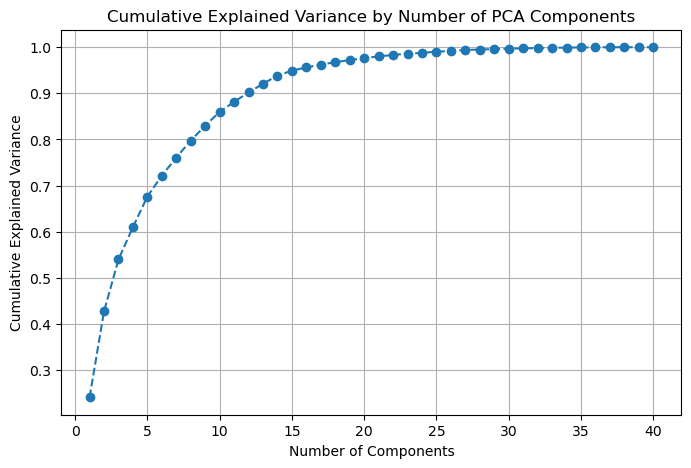

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming X_normalized (or X_resampled) is your feature matrix
# We can use either; here I demonstrate using X_resampled from previous oversampling
# If you want to use a different dataset, replace X_resampled with your desired dataset

# Define the PCA estimator and fit the data
pca = PCA()
pca.fit(X_resampled)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


## 2.6. Logistic Regression 

Logistic regression with PCA can be a suitable model for this type of problem, as it retains explainability (the PCA transformation can be reversed) and solves the collinearity issue. Cross-validation is used to reduce the chances of overfitting. To address the imbalance, the SMOTE technique, similar to oversampling, is applied.

In [9]:
# Initial configuration
n_splits = 5
n_components = 0.90  
metrics = []

# Stratified cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_normalized, y):
    # Data splitting
    X_train, X_test = X_normalized.iloc[train_index], X_normalized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 1. STRICT 1:1 OVERSAMPLING ----------------------------------------------
    smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Exact 50-50 balance
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    # Verify class balance
    unique, counts = np.unique(y_train_bal, return_counts=True)
    print(f"\nClass distribution after SMOTE: {dict(zip(unique, counts))}")
    
    # 2. PCA ON BALANCED TRAINING DATA -----------------------------------------
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_bal)
    X_test_pca = pca.transform(X_test)  # Apply same transformation to test
    
    # 3. MODEL TRAINING -------------------------------------------------------
    X_train_pca = sm.add_constant(X_train_pca)
    X_test_pca = sm.add_constant(X_test_pca, has_constant='add')
    
    try:
        model = sm.Logit(y_train_bal, X_train_pca)
        result = model.fit(method='bfgs', maxiter=200, disp=0)  # Increased iterations
    except Exception as e:
        print(f"Fit error: {str(e)}")
        continue
    
    # 4. PREDICTION & EVALUATION ----------------------------------------------
    y_pred_proba = result.predict(X_test_pca)
    y_pred = np.round(y_pred_proba)
    
    cm = confusion_matrix(y_test, y_pred)
    metrics.append({
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'tn': cm[0,0], 'fp': cm[0,1],
        'fn': cm[1,0], 'tp': cm[1,1]
    })

# Final metrics
results_df = pd.DataFrame(metrics)
print("\nAverage metrics:")
print(results_df.mean())

print("\nAverage confusion matrix:")
print(f"TN: {results_df.tn.mean():.1f}  FP: {results_df.fp.mean():.1f}")
print(f"FN: {results_df.fn.mean():.1f}  TP: {results_df.tp.mean():.1f}")
    


Class distribution after SMOTE: {0: 55325, 1: 55325}

Class distribution after SMOTE: {0: 55325, 1: 55325}

Class distribution after SMOTE: {0: 55326, 1: 55326}

Class distribution after SMOTE: {0: 55326, 1: 55326}

Class distribution after SMOTE: {0: 55326, 1: 55326}

Average metrics:
accuracy        0.670952
precision       0.439857
recall          0.655818
f1              0.526551
roc_auc         0.724286
tn           9361.200000
fp           4470.200000
fn           1842.200000
tp           3510.200000
dtype: float64

Average confusion matrix:
TN: 9361.2  FP: 4470.2
FN: 1842.2  TP: 3510.2


To compare the results of logistic regression, they are benchmarked against XGBoost. XGBoost is not interpretable, so it should not be used in applications requiring very high robustness. However, it can help determine if the interpretable model is achieving good results with the currently available data.

In [10]:
# Initial configuration
n_splits = 5
n_components = 0.90 
metrics = []

# Stratified cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold_idx, (train_index, test_index) in enumerate(skf.split(X_normalized, y)):
    # Data splitting
    X_train, X_test = X_normalized.iloc[train_index], X_normalized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 1. STRICT 1:1 OVERSAMPLING ----------------------------------------------
    smote = SMOTE(sampling_strategy=1.0, random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    # Verify balance
    unique, counts = np.unique(y_train_bal, return_counts=True)
    print(f"\nFold {fold_idx+1} - Class distribution after SMOTE: {dict(zip(unique, counts))}")
    
    # 2. DIMENSIONALITY REDUCTION ---------------------------------------------
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_bal)
    X_test_pca = pca.transform(X_test)
    
    # 3. XGBOOST CLASSIFIER WITH IMBALANCE HANDLING ---------------------------
    # Calculate original class ratio for scale_pos_weight
    original_ratio = sum(y_train == 0) / sum(y_train == 1)
    
    model = XGBClassifier(
        scale_pos_weight=original_ratio, 
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False
    )
    
    # 4. TRAINING & EVALUATION ------------------------------------------------
    model.fit(X_train_pca, y_train_bal)
    
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]  # Probability of class 1
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    metrics.append({
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'tn': cm[0,0], 'fp': cm[0,1],
        'fn': cm[1,0], 'tp': cm[1,1]
    })

# Final results
results_df = pd.DataFrame(metrics)
print("\nAverage metrics:")
print(results_df.mean())

print("\nAverage confusion matrix:")
print(f"TN: {results_df.tn.mean():.1f}  FP: {results_df.fp.mean():.1f}")
print(f"FN: {results_df.fn.mean():.1f}  TP: {results_df.tp.mean():.1f}")


Fold 1 - Class distribution after SMOTE: {0: 55325, 1: 55325}


c:\Users\Cash\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 2 - Class distribution after SMOTE: {0: 55325, 1: 55325}


c:\Users\Cash\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 3 - Class distribution after SMOTE: {0: 55326, 1: 55326}


c:\Users\Cash\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 4 - Class distribution after SMOTE: {0: 55326, 1: 55326}


c:\Users\Cash\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Fold 5 - Class distribution after SMOTE: {0: 55326, 1: 55326}


c:\Users\Cash\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Average metrics:
accuracy        0.574485
precision       0.387141
recall          0.900605
f1              0.541505
roc_auc         0.773523
tn           6200.400000
fp           7631.000000
fn            532.000000
tp           4820.400000
dtype: float64

Average confusion matrix:
TN: 6200.4  FP: 7631.0
FN: 532.0  TP: 4820.4


The results of both models are similar, which seems to suggest that further improvements in predictive capacity require continued work on the data.